In [1]:
# Standard libraries

import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier,IsolationForest
from imblearn.over_sampling import ADASYN

import pickle

# Sklearn imports

from functions_model import plot_ROC,plot_confusion_matrix,plot_learning_curve,plot_ROC_kfolds

from sklearn.model_selection import (
        train_test_split,
        learning_curve,
        StratifiedKFold,
        cross_val_score,
        RandomizedSearchCV,
        GridSearchCV
        )

from sklearn.metrics import (
        roc_auc_score,
        roc_curve,
        precision_recall_curve,
        confusion_matrix,
        auc,
        cohen_kappa_score,
        accuracy_score,
        precision_score,
        recall_score
        )

import warnings
warnings.filterwarnings("ignore")

# Functions

In [2]:
def get_file(file_path: str) -> pd.DataFrame:
    """
    Reads csv file in standardized format.

    :param file_path: str of file path
    :returns: df containing data
    """
    
    df = pd.read_csv(
            file_path,
            sep='|',
            encoding='utf-8',
            na_values='',
            low_memory=False,
            decimal=','
            )

    return df

def backtesting(data,var_probab,var_target,cant,cutoff):

    dataframe = data.copy()
    #dataframe[var_probab] = round(dataframe[var_probab]*1000)

    if np.isnan(cutoff).any():
        dataframe['rangos'] = pd.qcut(dataframe[var_probab],cant,precision=0,duplicates='drop')
    else:
        dataframe['rangos'] = pd.cut(dataframe[var_probab],cutoff,precision=0,include_lowest=True)
    
    dataframe['target'] = dataframe[var_target]
    
    table = pd.DataFrame(dataframe[['rangos','target']].groupby('rangos').size())
    table = table.sort_values(by ='rangos', ascending=True)
    table.rename(columns={0: 'total cat'}, inplace=True)

    table = table.join(dataframe[['rangos','target']].groupby(['rangos']).sum())
    table.rename(columns={'target': 'var 1'}, inplace=True)
    table['var 0'] = table['total cat'] - table['var 1']
    
    table.insert(loc=1, column='% total cat', value=round((table['total cat'] / dataframe.shape[0])*100,2))
    table.insert(loc=2, column='total acum', value=table['% total cat'].cumsum())
    
    table.insert(loc=4, column='tasa var 1', value=round((table['var 1']/table['total cat'])*100,2))
    table.insert(loc=6, column='tasa var 0', value=round((table['var 0']/table['total cat'])*100,2))
    
    table.insert(loc=5, column='var 1 acum', value=round((table['var 1'].cumsum()/table['var 1'].sum())*100,2))
    table.insert(loc=8, column='var 0 acum', value=round((table['var 0'].cumsum()/table['var 0'].sum())*100,2))
    
    table['KS'] = round(abs(table['var 1 acum']-table['var 0 acum']),2)
    
#     table['tasa var 0 acum'] = [round((table.iloc[0+i:len(table),table.columns.get_loc('var 0')].sum()/
#                                       table.iloc[0+i:len(table),table.columns.get_loc('total cat')].sum())*100,2) for i in range(0,len(table))]
    
#     table['odds acum'] = [round((table.iloc[0+i:len(table),table.columns.get_loc('var 1')].sum()/
#                                  table.iloc[0+i:len(table),table.columns.get_loc('var 0')].sum()),2) for i in range(0,len(table))]
    
    table['odds'] = round(table['var 1']/table['var 0'],2)
    
    comp = pd.DataFrame([int(np.where(table.iloc[0+i,table.columns.get_loc('odds')]<= \
                                      table.iloc[1+i,table.columns.get_loc('odds')],0,1)) for i in range(0,len(table)-1)])
    
    table['quiebres'] = pd.concat([pd.DataFrame([0]),comp]).set_index(table.index)
     
    table = table.sort_values(by ='rangos', ascending=False)
    
    table.reset_index(inplace=True)
    
    last_row = pd.DataFrame(['total',
                             table['total cat'].sum(),
                             round(table['% total cat'].sum()),
                             '',
                             table['var 1'].sum(),
                             round((table['var 1'].sum()/table['total cat'].sum())*100,2),
                             '',
                             table['var 0'].sum(),
                             round((table['var 0'].sum()/table['total cat'].sum())*100,2),
                             '',
                             table['KS'].max(),
#                              '',
#                              '',
                             round(table['var 1'].sum()/table['var 0'].sum(),2),
                             table['quiebres'].sum()]).T
    
    last_row.columns = table.columns

    table = table.append(last_row)
    
    table.drop(['var 1 acum','var 0 acum'],axis=1,inplace=True)
    
    return table

In [13]:
### Reading file

keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\preprocessing\\')+'data_preprocessed_train.csv'

df_total = get_file(path)

In [14]:
print(df_total.shape)
df_total.head()

(55419, 91)


,fraud,claim_amount,woe_diff_days_claim_reg_ocu,diff_days_claim_reg_ocu,woe_claim_postal_code,woe_claim_postal_code_cat_medium_fraud,woe_claim_postal_code_cat_high_fraud,woe_claim_cause,claim_cause_cat_other,claim_cause_cat_remaining_cats,...,policy_num_changes,woe_policy_num_claims,policy_num_claims,woe_policy_premium_100,policy_premium_100,woe_policy_coverage_1000,policy_coverage_1000,woe_policy_coverage_type,woe_policy_coverage_type_cat_medium_fraud,woe_policy_coverage_type_cat_high_fraud
0,0,826.33,22.4187,7,128.4157,0,0,62.2094,0,0,...,0,7.644,0,29.4073,NaN,46.8422,NaN,29.2866,1,0
1,0,2178.6,-85.707,45,-3.4511,1,0,62.2094,0,0,...,0,7.644,0,29.4073,NaN,46.8422,NaN,29.2866,1,0
2,0,717.0,114.6187,33,128.4157,0,0,62.2094,0,0,...,0,7.644,0,29.4073,NaN,46.8422,NaN,29.2866,1,0
3,0,4280.69,22.4187,7,128.4157,0,0,62.2094,0,0,...,0,7.644,0,29.4073,NaN,46.8422,NaN,29.2866,1,0
4,0,1709.46,114.6187,27,128.4157,0,0,62.2094,0,0,...,0,7.644,0,29.4073,NaN,46.8422,NaN,29.2866,1,0


In [15]:
df_total.dropna(axis=1, how='any', inplace=True)

In [16]:
print(df_total.shape)

(55419, 79)


In [17]:
# df_total[df_total['claim_amount']==4895]

In [18]:
columns = df_total.columns[np.where(df_total.dtypes == 'object')]

df_total[columns] = df_total[columns].astype(float)

In [33]:
cols_not_model = ['fraud','claim_amount']

cols_data = [col for col in df_total.columns if col not in cols_not_model]

x_data = df_total[cols_data].copy()

In [34]:
clf = IsolationForest()
clf.fit(x_data)

IsolationForest()

In [35]:
pred = clf.predict(x_data)
x_data['anomaly'] = pred

In [36]:
outliers = x_data.loc[x_data['anomaly']==-1]
outlier_index = list(outliers.index)
#print(outlier_index)
#Find the number of anomalies and normal points here points classified -1 are anomalous
print(x_data['anomaly'].value_counts())

 1    37821
-1    17598
Name: anomaly, dtype: int64


In [ ]:
x_data = x_data[[
  'woe_third_party_1_postal_code',
  'woe_claim_num_vehicles',
  'woe_claim_postal_code',
#   'woe_policy_holder_postal_code',
  'woe_driver_postal_code',
  'woe_claim_cause',
  'woe_age_driver',
  'woe_months_vehicle_regist',
  'woe_claim_vehicle_cyl',
  'woe_diff_days_claim_reg_ocu',
  'woe_claim_vehicle_load',
#   'claim_cause_cat_other',
#   'woe_age_policy_holder',
  'claim_num_third_parties',
  'woe_third_party_1_vehicle_type',
  'woe_years_policy_start',
  'woe_claim_vehicle_power',
  'woe_policy_coverage_1000',
#   'diff_days_claim_reg_ocu',
  'woe_policy_num_changes',
#   'woe_driver_postal_code_cat_medium_fraud',
#   'woe_claim_postal_code_cat_medium_fraud',
  'woe_years_policy_expiry',
  'woe_policy_coverage_type',
  'woe_policy_premium_100',
#   'policy_num_changes',
#   'woe_claim_num_third_parties',
  'woe_claim_police',
  'woe_claim_vehicle_brand',
  'woe_years_vehicle_regist'
]]

In [7]:
print(x_data.shape)
x_data.head()

(55419, 89)


,woe_diff_days_claim_reg_ocu,diff_days_claim_reg_ocu,woe_claim_postal_code,woe_claim_postal_code_cat_medium_fraud,woe_claim_postal_code_cat_high_fraud,woe_claim_cause,claim_cause_cat_other,claim_cause_cat_remaining_cats,woe_claim_liable,claim_liable_cat_N,...,policy_num_changes,woe_policy_num_claims,policy_num_claims,woe_policy_premium_100,policy_premium_100,woe_policy_coverage_1000,policy_coverage_1000,woe_policy_coverage_type,woe_policy_coverage_type_cat_medium_fraud,woe_policy_coverage_type_cat_high_fraud
0,22.4187,7,128.4157,0,0,62.2094,0,0,57.2768,0,...,0,7.644,0,29.4073,NaN,46.8422,NaN,29.2866,1,0
1,-85.7070,45,-3.4511,1,0,62.2094,0,0,57.2768,0,...,0,7.644,0,29.4073,NaN,46.8422,NaN,29.2866,1,0
2,114.6187,33,128.4157,0,0,62.2094,0,0,57.2768,0,...,0,7.644,0,29.4073,NaN,46.8422,NaN,29.2866,1,0
3,22.4187,7,128.4157,0,0,62.2094,0,0,57.2768,0,...,0,7.644,0,29.4073,NaN,46.8422,NaN,29.2866,1,0
4,114.6187,27,128.4157,0,0,62.2094,0,0,57.2768,0,...,0,7.644,0,29.4073,NaN,46.8422,NaN,29.2866,1,0


In [ ]:
# corr_mat = x_data.corr()

# plt.figure(figsize=(10, 10))

# sns.heatmap(
#         corr_mat,
#         vmax=1,
#         vmin=-1,
#         square=False,
#         annot=True,
#         cmap="Blues" #PiYG
#         )

# plt.tight_layout()

In [37]:
var_target = 'fraud'

In [38]:
y_data = df_total[var_target]

# Training

In [39]:
# Seed for random methods (every result in the code should be reproducible)

SEED = 123

# Test size for train/test split

TEST_SIZE = 0.30

x_train, x_test, y_train, y_test = train_test_split(
        x_data,
        y_data,
        test_size=TEST_SIZE,
        random_state=SEED
        )

In [23]:
# ada = ADASYN(random_state=SEED)

In [24]:
# x_train, y_train = ada.fit_resample(x_train, y_train)

In [40]:
print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)

(38793, 78) (16626, 78)
(38793,) (16626,)


In [50]:
# xgb_class = xgb.XGBClassifier(n_jobs=-1,
#                               seed=SEED,
#                               objective='binary:logistic',
#                               use_label_encoder =False,
#                               eval_metric="error",
#                               max_depth=5,
# #                              max_delta_step=1
#                               )

xgb_class = RandomForestClassifier(n_jobs=-1,
                                   random_state=SEED,
                                   max_depth=6)

In [51]:
x_train.reset_index(drop=True,inplace=True)
x_test.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)


Modelo Insurance Claims: AUC Score XGBoost: 0.954634


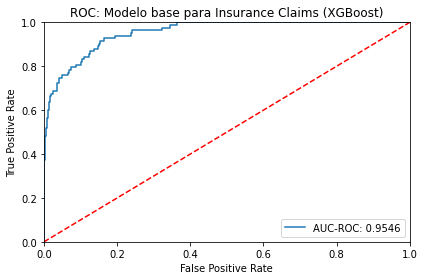

In [52]:
title = 'Insurance Claims'

xgb_class.fit(x_train, y_train)

preds_xgb = xgb_class.predict(x_test)
probab_xgb = xgb_class.predict_proba(x_test)

xgb_roc_auc = roc_auc_score(y_test, probab_xgb[:, 1])

print('\nModelo '
          + title + ': AUC Score XGBoost: %f' % xgb_roc_auc)

fpr, tpr, thresholds = roc_curve(y_test, probab_xgb[:, 1])

plot_ROC(fpr, tpr, title='ROC: Modelo base para '
             + title + ' (XGBoost)', auc=xgb_roc_auc)

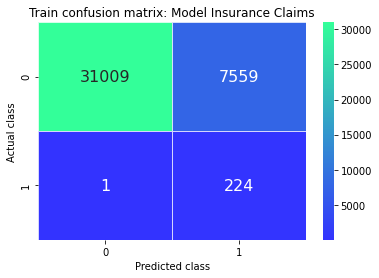

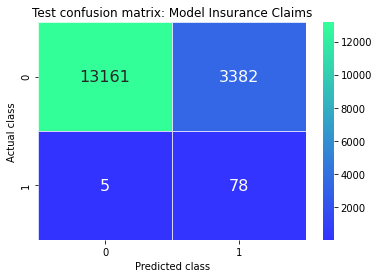

AUC-ROC: 95.46
Precision (train): 2.88
Precision (test): 2.25
Sensibilidad (Recall train): 99.56
Sensibilidad (Recall test): 93.98
Especificidad (train): 80.4
Especificidad (test): 79.56
Kappa (train): 4.52
Kappa (test): 3.46
Accuracy Rate (train): 80.51
Accuracy Rate (test): 79.63
Var.Target Rate (train): 0.58
Var.Target Rate (test): 0.5
Var.Target Rate (total): 0.56


In [53]:
#th = 0.005 #RandomForest
th = 0.005

y_test_pred = (probab_xgb[:, 1]>th).astype(int)
y_train_pred = (xgb_class.predict_proba(x_train)[:, 1]>th).astype(int)

cm=confusion_matrix(y_test, y_test_pred)
cm_t=confusion_matrix(y_train, y_train_pred)

plot_confusion_matrix(
                cm_t,
                title='Train confusion matrix: Model ' + title
                )

plot_confusion_matrix(
                cm,
                title='Test confusion matrix: Model ' + title
                )

print( 'AUC-ROC:', round(xgb_roc_auc*100,2) )

print( 'Precision (train):', round(precision_score(y_train, y_train_pred)*100,2) )
print( 'Precision (test):', round(precision_score(y_test, y_test_pred)*100,2) )

print( 'Sensibilidad (Recall train):', round(recall_score(y_train, y_train_pred)*100,2) )
print( 'Sensibilidad (Recall test):', round(recall_score(y_test, y_test_pred)*100,2) )

print( 'Especificidad (train):', round(cm_t[0,0]/cm_t[0,:].sum()*100,2) )
print( 'Especificidad (test):', round(cm[0,0]/cm[0,:].sum()*100,2) )

print( 'Kappa (train):', round(cohen_kappa_score(y_train, y_train_pred)*100,2) )
print( 'Kappa (test):', round(cohen_kappa_score(y_test,y_test_pred)*100,2) )

print( 'Accuracy Rate (train):', round(accuracy_score(y_train, y_train_pred)*100,2) )
print( 'Accuracy Rate (test):', round(accuracy_score(y_test, y_test_pred)*100,2) )

print( 'Var.Target Rate (train):', round(y_train.sum()/y_train.shape[0]*100,2) )
print( 'Var.Target Rate (test):', round(y_test.sum()/y_test.shape[0]*100,2) )
print( 'Var.Target Rate (total):', round(y_data.sum()/y_data.shape[0]*100,2) )

In [54]:
# =========== Feature importance XGBoost ===========
# fig, ax = plt.subplots(figsize=(8,6))
# xgb.plot_importance(
#             xgb_class,
#             importance_type='gain',
#             title='Feature Importance: Model ' + title,
#             ax=ax,
#             color = 'purple')
# plt.show()

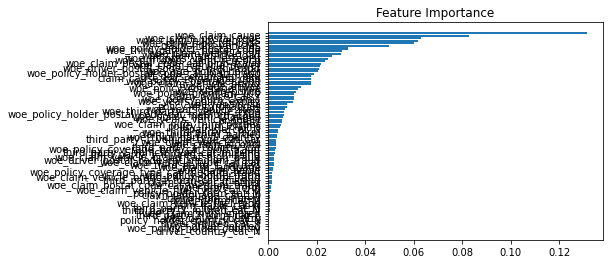

In [55]:
# =========== Feature importance Random Forest ===========

indices = np.argsort(xgb_class.feature_importances_)
variables = [x_data.columns[i] for i in indices]

# Graph of features importances
# plt.figure(figsize=(16, 8))
plt.title("Feature Importance")
plt.barh(range(x_data.shape[1]), xgb_class.feature_importances_[indices])
plt.yticks(range(x_data.shape[1]), variables, fontsize = 10)
plt.show()

In [48]:
data_test = pd.DataFrame(y_test).join(pd.DataFrame({'score':probab_xgb[:, 1]}))
data_train = pd.DataFrame(y_train).join(pd.DataFrame({'score':xgb_class.predict_proba(x_train)[:, 1]}))

In [49]:
print(data_train['score'].min())
print(data_train['score'].max())

0.0003398855290412072
0.667749024090886


In [ ]:
# plt.hist(round(data['score']*1000,2),bins=30)
# plt.hist(data_test['score'],bins=30)
plt.hist(data_train['score'],bins=50,color='purple')
plt.show()

In [ ]:
tabla = backtesting(data_test,'score',var_target,10,np.nan)
tabla

In [ ]:
tabla = backtesting(data_train,'score',var_target,10,np.nan)
tabla

In [ ]:
# data_total = pd.concat([data_train,data_test])

In [ ]:
#Threshold function

def Find_Optimal_Cutoff(target, predicted):

    """

    Find the optimal probability cutoff point for a classification model related to event rate

    Parameters

    ----------

    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns

    -------    

    optimal cutoff value

    """

    fpr, tpr, threshold = roc_curve(target, predicted)

    i = np.arange(len(tpr))

    roc = pd.DataFrame({'tf' : pd.Series(tpr - fpr, index = i), 'threshold' : pd.Series(threshold, index=i)})

    roc_t = roc.iloc[roc['tf'].values.argmax(), :]

    return roc_t['threshold']

# y_predict_train = xgb_model2.predict_proba(X_train_final)

# proba_train = y_predict_train[:, 1]

# proba_train = pd.Series(proba_train)

threshold = Find_Optimal_Cutoff(y_test, probab_xgb[:, 1])

print('Pto corte dataset test:', threshold)

# Cross validation

In [ ]:
x_train_tun = x_train.copy()
y_train_tun = y_train.copy()

In [ ]:
# Seed for random methods (every result in the code should be reproducible)
# sns.set()
SEED = 123

# Test size for train/test split

TEST_SIZE = 0.30

# Explore performance of baseline model in more depth (learning curve and
# average of kfolds to improve stability of results)

print('\nTraining baseline model in kfolds (see output plots)')

# Plotting learning curve

for x, y, title in zip(
        [x_train_tun],
        [y_train_tun],
        ['insurance claims']
        ):
    # Iterate for cobranza

    if x is None:
        # Skip if one case is not being considered

        continue

    # Train/test split

    x_train, x_test, y_train, y_test = train_test_split(
            x,
            y,
            test_size=TEST_SIZE,
            random_state=SEED
            )
    
    x_train.reset_index(drop=True,inplace=True)
    x_test.reset_index(drop=True,inplace=True)
    y_train.reset_index(drop=True,inplace=True)
    y_test.reset_index(drop=True,inplace=True)

#     xgb_class_cs = xgb.XGBClassifier(n_jobs=-1,
#                                      seed=SEED,
#                                      objective='binary:logistic',
#                                      use_label_encoder =False,
#                                      eval_metric="error")

    xgb_class_cs = RandomForestClassifier(n_jobs=-1,
                                          random_state=SEED,
                                          max_depth=5)
    
#     xgb_class_cs = RandomForestClassifier(n_estimators = 500,     # Número de modelos a crear 
#                                  criterion = 'gini',     # el criterio de particionamiento de un conjunto de datos
#                                  bootstrap = True,       # Utilizar reemplazo en el muestreo de los registros de aprendizaje
#                                  oob_score = True,       # Evaluar cada modelo con los registros no utilizados en su aprendizaje 
#                                  n_jobs = -1,            # Número de cores a utilizar
#                                  random_state = SEED,    # random seed para el generador aleatorio
#                                  verbose = 0)            # controla la cantidad de información a reportar

    # Define cross validation

    kfold = StratifiedKFold(n_splits=5)

    # Learning curve

    plot_learning_curve(
            xgb_class_cs,
            'Curva de aprendizaje XGBoost: Modelo base para ' + title,
            x_train,
            y_train,
            cv=kfold
            )

    # Plotting ROC curve for several kfolds

    plot_ROC_kfolds(
            xgb_class_cs,
            x_train,
            y_train,
            kfold,
            'Curvas ROC para kfolds: Modelo base para ' + title
            )

# Save Model as Pickle

In [ ]:
keyword = os.getcwd().split('\\')[-1]
path = os.getcwd().replace(keyword,'Data\\model\\')
path

In [ ]:
with open(path+'claims_assign1.pkl', 'wb') as f:
    pickle.dump(xgb_class, f)

In [ ]:
# load the model from disk
model_xgb = pickle.load(open(path+'claims_assign1.pkl', 'rb'))

In [ ]:
model_xgb

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
        x_data,
        y_data,
        test_size=TEST_SIZE,
        random_state=SEED
       )

In [ ]:
x_train.reset_index(drop=True,inplace=True)
x_test.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

In [ ]:
title = 'Insurance Claims'

preds_xgb = model_xgb.predict(x_test)
probab_xgb = model_xgb.predict_proba(x_test)

xgb_roc_auc = roc_auc_score(y_test, probab_xgb[:, 1])

print('\nModelo '
          + title + ': AUC Score XGBoost: %f' % xgb_roc_auc)

fpr, tpr, thresholds = roc_curve(y_test, probab_xgb[:, 1])

plot_ROC(fpr, tpr, title='ROC: Modelo base para '
             + title + ' (XGBoost)', auc=xgb_roc_auc)

In [ ]:
#th = 0.005 #RandomForest
th = 0.005

y_test_pred = (probab_xgb[:, 1]>th).astype(int)
y_train_pred = (xgb_class.predict_proba(x_train)[:, 1]>th).astype(int)

cm=confusion_matrix(y_test, y_test_pred)
cm_t=confusion_matrix(y_train, y_train_pred)

plot_confusion_matrix(
                cm_t,
                title='Train confusion matrix: Model ' + title
                )

plot_confusion_matrix(
                cm,
                title='Test confusion matrix: Model ' + title
                )

print( 'AUC-ROC:', round(xgb_roc_auc*100,2) )

print( 'Precision (train):', round(precision_score(y_train, y_train_pred)*100,2) )
print( 'Precision (test):', round(precision_score(y_test, y_test_pred)*100,2) )

print( 'Sensibilidad (Recall train):', round(recall_score(y_train, y_train_pred)*100,2) )
print( 'Sensibilidad (Recall test):', round(recall_score(y_test, y_test_pred)*100,2) )

print( 'Especificidad (train):', round(cm_t[0,0]/cm_t[0,:].sum()*100,2) )
print( 'Especificidad (test):', round(cm[0,0]/cm[0,:].sum()*100,2) )

print( 'Kappa (train):', round(cohen_kappa_score(y_train, y_train_pred)*100,2) )
print( 'Kappa (test):', round(cohen_kappa_score(y_test,y_test_pred)*100,2) )

print( 'Accuracy Rate (train):', round(accuracy_score(y_train, y_train_pred)*100,2) )
print( 'Accuracy Rate (test):', round(accuracy_score(y_test, y_test_pred)*100,2) )

print( 'Var.Target Rate (train):', round(y_train.sum()/y_train.shape[0]*100,2) )
print( 'Var.Target Rate (test):', round(y_test.sum()/y_test.shape[0]*100,2) )
print( 'Var.Target Rate (total):', round(y_data.sum()/y_data.shape[0]*100,2) )

# feature importance

In [ ]:
x_train_tun, x_test_tun, y_train_tun, y_test_tun = train_test_split(
        x_data,
        y_data,
        test_size=TEST_SIZE,
        random_state=SEED
       )

In [ ]:
y_train_tun.shape

In [ ]:
AVG_FEATURE_BUCKETS = True
N_BUCKETS = 10 
N_TRAINING_MODEL = 200
N_FEATURES = 30  

# Calculate feature importance and average values vs propensity buckets

if AVG_FEATURE_BUCKETS:

    top_feat_list = dict({})        # List of top features for cobranza

    for x, y, title in zip(
        [x_train_tun],
        [y_train_tun],
        ['insurance claims']
        ):
        # Iterate for cobranza

        if x is None:
            # Skip if one case is not being considered

            continue

        print('\nCalculating feature importance for ' + title + ':')

        N_VARS = x.shape[1]                 # Number of total variables

        # Cummulative sum of feat importances for each variable over iterations

        cum_feat_importance = {_: 0 for _ in x.columns}

        # Sum of feature importances for each bucket

        sum_feature_buckets = {
                _: [0] * N_BUCKETS for _ in x.columns
                }

        print('\nStarting iterations:')

        for i in range(N_TRAINING_MODEL):
            # Training models

            if (i + 1) % 20 == 0:
                # Print iteration number when divisible by 10

                print(
                        'Training iter: ' + str(i + 1) + '/'
                        + str(N_TRAINING_MODEL)
                        )

            x_train, x_test, y_train, y_test = train_test_split(
                x,
                y,
                test_size=TEST_SIZE,
                # random_state=SEED     # Average over different folds
                )
            
            x_train.reset_index(drop=True,inplace=True)
            x_test.reset_index(drop=True,inplace=True)
            y_train.reset_index(drop=True,inplace=True)
            y_test.reset_index(drop=True,inplace=True)

            # XGBoost classifier

            xgb_class = xgb.XGBClassifier(n_jobs=-1,
                                          #seed=SEED,
                                          objective='binary:logistic',
                                          use_label_encoder =False,
                                          eval_metric="error")      # No fixed seed

#             xgb_class = RandomForestClassifier(n_estimators = 500,     # Número de modelos a crear 
#                                  criterion = 'gini',     # el criterio de particionamiento de un conjunto de datos
#                                  bootstrap = True,       # Utilizar reemplazo en el muestreo de los registros de aprendizaje
#                                  oob_score = True,       # Evaluar cada modelo con los registros no utilizados en su aprendizaje 
#                                  n_jobs = -1,            # Número de cores a utilizar
#                                  random_state = SEED,    # random seed para el generador aleatorio
#                                  verbose = 0)            # controla la cantidad de información a reportar

            xgb_class.fit(x_train, y_train)
            probab_xgb = xgb_class.predict_proba(x_test)

            # Calculate feature importance and populate dictionary

            feat_importance_dict = xgb_class.get_booster().get_score(
                importance_type="gain")

            # Add to cummulative feat importance

            cum_feat_importance = {
                    key: (
                            feat_importance_dict.get(key, 0)
                            + cum_feat_importance.get(key, 0)
                         )
                         for key in set(
                            feat_importance_dict)
                                | set(cum_feat_importance)
                                }

            # Add probability output as column

            X2 = x_test.reset_index()
            X2.drop(['index'], axis=1, inplace=True)

            prob = pd.DataFrame(probab_xgb[:, 1])
            prob.columns = ['pred_prob']

            output = X2.join(prob, how='inner')

            # Create probability buckets

#            output['prob_buckets'] = output.pred_prob.apply(
#                    lambda x: int(x * N_BUCKETS)
#                    )

            output['prob_percent'] = pd.qcut(prob.pred_prob, 10, labels=False, duplicates='drop')

            # Group by probability bucket taking the average of all features

            gb = output.groupby('prob_percent').mean()

            # Add all feature averages and populate dictionary

            for col in range(N_VARS):

                for _ in range(N_BUCKETS):

                    try:
                        # A bucket might not exist

                        sum_feature_buckets[
                                gb.columns[col]][_] += gb.loc[_][col]

                    except KeyError:
                        # In which case we do nothing

                        pass

        # Select the top features

        top_feat = sorted(
                cum_feat_importance,
                key=cum_feat_importance.get,
                reverse=True
                )[:N_FEATURES]

        avg_feature_vals = dict({})      # Dict to store avg feature values

        # Transform sum to avg
        # This represents the overall avg value of each feature for each bucket
        # It's assumed that the number of samples per bucket does't change much

        for key in sum_feature_buckets.keys():

            avg_feature_vals[key] = [
                    _ / N_TRAINING_MODEL for _ in sum_feature_buckets[key]
                    ]

        final_avg_feature = dict({})        # Selecting top features

        for _ in top_feat:

            final_avg_feature[_] = avg_feature_vals[_]

        # Plot results

        plt.figure(figsize=(14, 10))

        for idx, _ in enumerate(top_feat):

            plt.subplot(
                    int(np.sqrt(N_FEATURES)) + 1,
                    int(np.sqrt(N_FEATURES)), idx + 1
                    )

            plt.plot(range(N_BUCKETS), final_avg_feature[_], '-o')
            plt.title(_)

        # plt.suptitle('Variables importantes para modelo ' + title)
        plt.tight_layout()

        # Plot feature importances

        plt.figure(figsize=(14, 10))

        sorted_feat = [x for y, x in sorted(
                zip(cum_feat_importance.values(), cum_feat_importance.keys()))]

        plt.barh(
                sorted_feat,
                [_ / N_TRAINING_MODEL for _ in sorted(
                        cum_feat_importance.values()
                        )
                ]
                )

        plt.title('Importancia de variables: Modelo ' + title)
        plt.grid(alpha=0.4)
        plt.tight_layout()

        # Export to xlsx

        #df = pd.DataFrame(final_avg_feature).T

        #df.columns = [str(_ * 10) + '-' + str((_+1) * 10) for _ in range(10)]

        #df.to_json(FEATURE_VALUES_BUCKETS_FILENAMES[title], orient='split')

        # Save top features for each model

        top_feat_list[title] = top_feat

    #print('\nFeature values saved to files!')

In [ ]:
top_feat_list